Create surrogate neural population responses during natural behavior trials using reduced populations with parameters chosen based on theoretical considerations.

In [1]:
%matplotlib inline
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
from scipy import signal, stats
from sklearn import linear_model
import sys
import warnings; warnings.filterwarnings("ignore")

from aux import get_seg
from disp import set_plot
from my_torch import skl_fit_ridge
from my_stats import nanpearsonr

from record import smlt_ppln_ma

cc = np.concatenate

FPS = 30.03  # sampling rate of behavioral data
DT = 1/FPS

STRAINS = ['NM91', 'ZH23']
STRAIN_KEY = '_'.join(STRAINS).lower()

PTRAIN = .8
NSPLIT = 30

TARG_BHV = 'MTN'
TWDWS = [.03, 1, 60]
TARGS = [f'{TARG_BHV}_MN_{twdw}' for twdw in TWDWS]

ALPHA = 10

In [2]:
PFX_BHV = f'data/simple/behav_xtd/behav_xtd'
PFX_NRL = f'data/simple/mlv/ma_red/temp_nrl/temp_ma_red_ppln'

FSTRAIN = 'data/simple/strains.csv'
MSTRAINS = [(pd.read_csv(FSTRAIN)['STRAIN'] == strain) for strain in STRAINS]
MSTRAIN = np.any(MSTRAINS, axis=0)
ISTRAIN = MSTRAIN.nonzero()[0]

NTR = len(ISTRAIN)
NTRAIN = int(round(PTRAIN*NTR))

Load behavioral data from Coen et al 2014

In [3]:
df_behav = pd.read_csv('data/simple/c_song_f_behav.csv')
df_behav

,ID,FRAME,T,Q,S,P,F,FFV,FFA,FLS,FRS,FMFV,FMLS
0,0,0,0.000000,1,0,0,0,0.231,0.0000,0.159,0.077,-0.058526,0.274257
1,0,1,0.033300,1,0,0,0,0.314,0.0385,0.025,0.044,0.100623,0.298490
2,0,2,0.066600,1,0,0,0,0.308,0.0025,0.029,0.011,0.147629,0.271865
3,0,3,0.099900,1,0,0,0,0.319,0.0020,0.016,0.016,0.091174,0.306112
4,0,4,0.133200,1,0,0,0,0.312,-0.0315,0.030,0.002,0.065871,0.306439
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4978565,275,27100,902.430902,1,0,0,0,0.217,0.0280,0.029,0.058,-0.171418,0.136184
4978566,275,27101,902.464202,1,0,0,0,0.210,-0.1045,0.138,0.322,0.032522,0.249171
4978567,275,27102,902.497502,1,0,0,0,0.008,-0.0910,0.034,0.260,0.033202,0.010844
4978568,275,27103,902.530803,1,0,0,0,0.028,0.0695,0.010,0.090,0.012059,0.027177


In [4]:
# split big df into dfs for individual trials
n_tr = np.max(df_behav.ID) + 1
dfs_tr = [df_behav[df_behav.ID == i] for i in ISTRAIN]

df_behav = None

In [5]:
# neural response fits from Baker data
df_ma_param = pd.read_csv('data/simple/neur/baker_ma_fit_param.csv')

In [6]:
# function for recording surrogate neural activity and predicting behavior
def record_fit(tau_rs, tau_as, x_ss, x_ps):
    n = len(tau_rs)
    r_cols = [f'R_{cr}' for cr in range(n)]
    
    # record data
    sys.stdout.write('R')
    for itr, df_tr in zip(ISTRAIN, dfs_tr):
        df_tr_nrl = df_tr.copy()

        i_s = np.array(df_tr['S']).astype(float)
        i_p = np.array(df_tr['P'] | df_tr['F']).astype(float)

        # simulate population response
        rs = smlt_ppln_ma(i_s, i_p, tau_rs, tau_as, x_ss, x_ps, DT)

        df_tr_nrl[r_cols] = rs

        np.save(f'{PFX_NRL}_tr_{itr}.npy', np.array([{'df': df_tr_nrl}]))
        
    sys.stdout.write('F')
    # fit neural -> behav regression model
    rslts = skl_fit_ridge(
        pfxs=[PFX_NRL, PFX_BHV],
        cols_x=r_cols,
        targs=TARGS,
        itr_all=ISTRAIN,
        ntrain=NTRAIN,
        nsplit=NSPLIT,
        alpha=ALPHA,
        verbose=False)
    r2_train_mns = {targ: np.mean([rslt.r2_train[targ] for rslt in rslts]) for targ in TARGS}
    r2_test_mns = {targ: np.mean([rslt.r2_test[targ] for rslt in rslts]) for targ in TARGS}
    
    r2_train_sds = {targ: np.std([rslt.r2_train[targ] for rslt in rslts]) for targ in TARGS}
    r2_test_sds = {targ: np.std([rslt.r2_test[targ] for rslt in rslts]) for targ in TARGS}
    
    sys.stdout.write('..')
    
    return r2_train_mns, r2_test_mns, r2_train_sds, r2_test_sds

# Test using full population

## Look for best response time scale given no selectivity

In [ ]:
# one-neuron population -- equal response to sine and pulse, sweep over response timescales
fname = '0_single_tau_r_sweep_no_sel'
tau_r_sweep = [.1, .5, 1, 2, 5, 10, 20, 30, 60, 90, 120, 180, 240, 300, 450, 600]
r2_test_mn_all = {targ: [] for targ in TARGS}

for tau_r in tau_r_sweep:
    tau_rs = tau_r*np.ones(1)
    tau_as = np.inf*np.ones(1)
    x_ss = np.array([.5])
    x_ps = np.array([.5])
    
    r2_test_mns = record_fit(tau_rs, tau_as, x_ss, x_ps)[1]
    for targ in TARGS:
        r2_test_mn_all[targ].append(r2_test_mns[targ])
        
np.save(f'data/simple/mlv/ma_red/{fname}.npy', np.array([{
    'tau_r_sweep': tau_r_sweep,
    'r2_test_mn_all': r2_test_mn_all
}]))

Recording:
.......................................................................................

Fitting:
Loading...


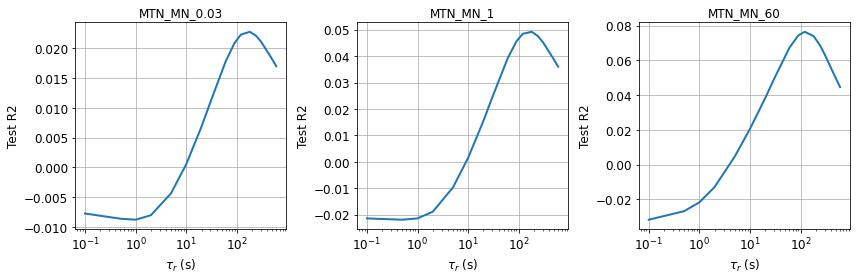

In [11]:
rslts = np.load(f'data/simple/mlv/ma_red/0_single_tau_r_sweep_no_sel.npy', allow_pickle=True)[0]
fig, axs = plt.subplots(1, 3, figsize=(12, 4), tight_layout=True)
for ax, targ in zip(axs, TARGS):
    ax.semilogx(
        rslts['tau_r_sweep'],
        rslts['r2_test_mn_all'][targ],
        lw=2
    )
    set_plot(ax, x_label=r'$\tau_r$ (s)', y_label='Test R2', title=targ, font_size=12)
    ax.grid()

## Look for best single nonselective neuron response & adaptation timescale

In [7]:
# one-neuron population -- equal response to sine and pulse, sweep over response timescales
fname = '0A_single_tau_r_tau_a_sweep_no_sel'
tau_r_sweep = [.5, 2, 5, 10, 30, 60, 120, 240, 450, 600]
tau_a_sweep = [.1, .5, 2, 10, 30, 60, 120, 400, np.inf]
r2_test_mn_all = {targ: np.nan*np.zeros((len(tau_r_sweep), len(tau_a_sweep))) for targ in TARGS}

for ctau_r, tau_r in enumerate(tau_r_sweep):
    for ctau_a, tau_a in enumerate(tau_a_sweep):
        tau_rs = tau_r*np.ones(1)
        tau_as = tau_a*np.ones(1)
        x_ss = np.array([.5])
        x_ps = np.array([.5])

        r2_test_mns = record_fit(tau_rs, tau_as, x_ss, x_ps)[1]
        for targ in TARGS:
            r2_test_mn_all[targ][ctau_r, ctau_a] = r2_test_mns[targ]
        
np.save(f'data/simple/mlv/ma_red/{fname}.npy', np.array([{
    'tau_r_sweep': tau_r_sweep,
    'tau_a_sweep': tau_a_sweep,
    'r2_test_mn_all': r2_test_mn_all
}]))

RF..RF..RF..RF..RF..RF..RF..RF..RF..RF..RF..RF..RF..RF..RF..RF..RF..RF..RF..RF..RF..RF..RF..RF..RF..RF..RF..RF..RF..RF..RF..RF..RF..RF..RF..RF..RF..RF..RF..RF..RF..RF..RF..RF..RF..RF..RF..RF..RF..RF..RF..RF..RF..RF..RF..RF..RF..RF..RF..RF..RF..RF..RF..RF..RF..RF..RF..RF..RF..RF..RF..RF..RF..RF..RF..RF..RF..RF..RF..RF..RF..RF..RF..RF..RF..RF..RF..RF..RF..RF..

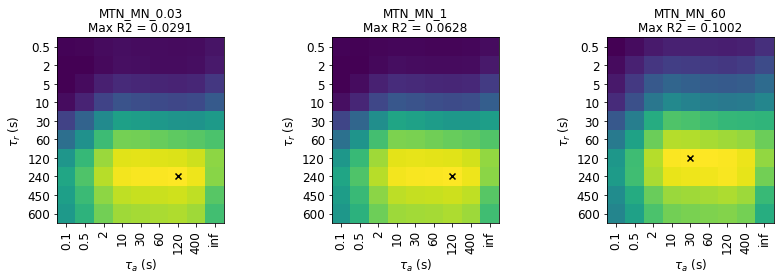

In [7]:
rslts = np.load(f'data/simple/mlv/ma_red/0A_single_tau_r_tau_a_sweep_no_sel.npy', allow_pickle=True)[0]
fig, axs = plt.subplots(1, 3, figsize=(12, 4), tight_layout=True)
for ax, targ in zip(axs, TARGS):
    ax.matshow(rslts['r2_test_mn_all'][targ])
    
    idx_best = np.unravel_index(
        rslts['r2_test_mn_all'][targ].flatten().argmax(),
        rslts['r2_test_mn_all'][targ].shape)
    
    max_r2 = rslts['r2_test_mn_all'][targ][idx_best[0], idx_best[1]]
    
    ax.scatter(idx_best[1], idx_best[0], c='k', marker='x', zorder=1)
    
    set_plot(
        ax,
        x_ticks=np.arange(len(rslts['tau_a_sweep'])),
        y_ticks=np.arange(len(rslts['tau_r_sweep'])),
        y_tick_labels=rslts['tau_r_sweep'],
        x_label=r'$\tau_a$ (s)',
        y_label=r'$\tau_r$ (s)',
        title=f'{targ}\nMax R2 = {max_r2:.4f}',
        font_size=12,
        )
    
    ax.set_xticklabels(rslts['tau_a_sweep'], rotation=90, fontsize=12)
    ax.xaxis.tick_bottom()

## Look for best single sine-selective neuron response & adaptation timescale

In [7]:
# one-neuron population -- equal response to sine and pulse, sweep over response timescales
fname = '0B_single_tau_r_tau_a_sweep_sine_sel'
tau_r_sweep = [.5, 2, 5, 10, 30, 60, 120, 240, 450, 600]
tau_a_sweep = [.1, .5, 2, 10, 30, 60, 120, 400, np.inf]
r2_test_mn_all = {targ: np.nan*np.zeros((len(tau_r_sweep), len(tau_a_sweep))) for targ in TARGS}

for ctau_r, tau_r in enumerate(tau_r_sweep):
    for ctau_a, tau_a in enumerate(tau_a_sweep):
        tau_rs = tau_r*np.ones(1)
        tau_as = tau_a*np.ones(1)
        x_ss = np.array([1])
        x_ps = np.array([0])

        r2_test_mns = record_fit(tau_rs, tau_as, x_ss, x_ps)[1]
        for targ in TARGS:
            r2_test_mn_all[targ][ctau_r, ctau_a] = r2_test_mns[targ]
        
np.save(f'data/simple/mlv/ma_red/{fname}.npy', np.array([{
    'tau_r_sweep': tau_r_sweep,
    'tau_a_sweep': tau_a_sweep,
    'r2_test_mn_all': r2_test_mn_all
}]))

RF..RF..RF..RF..RF..RF..RF..RF..RF..RF..RF..RF..RF..RF..RF..RF..RF..RF..RF..RF..RF..RF..RF..RF..RF..RF..RF..RF..RF..RF..RF..RF..RF..RF..RF..RF..RF..RF..RF..RF..RF..RF..RF..RF..RF..RF..RF..RF..RF..RF..RF..RF..RF..RF..RF..RF..RF..RF..RF..RF..RF..RF..RF..RF..RF..RF..RF..RF..RF..RF..RF..RF..RF..RF..RF..RF..RF..RF..RF..RF..RF..RF..RF..RF..RF..RF..RF..RF..RF..RF..

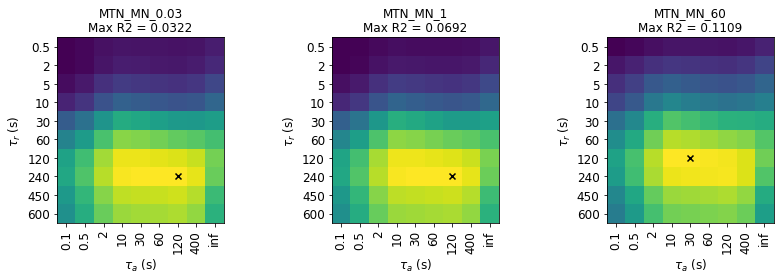

In [8]:
rslts = np.load(f'data/simple/mlv/ma_red/0B_single_tau_r_tau_a_sweep_sine_sel.npy', allow_pickle=True)[0]
fig, axs = plt.subplots(1, 3, figsize=(12, 4), tight_layout=True)
for ax, targ in zip(axs, TARGS):
    ax.matshow(rslts['r2_test_mn_all'][targ])
    
    idx_best = np.unravel_index(
        rslts['r2_test_mn_all'][targ].flatten().argmax(),
        rslts['r2_test_mn_all'][targ].shape)
    
    max_r2 = rslts['r2_test_mn_all'][targ][idx_best[0], idx_best[1]]
    
    ax.scatter(idx_best[1], idx_best[0], c='k', marker='x', zorder=1)
    
    set_plot(
        ax,
        x_ticks=np.arange(len(rslts['tau_a_sweep'])),
        y_ticks=np.arange(len(rslts['tau_r_sweep'])),
        y_tick_labels=rslts['tau_r_sweep'],
        x_label=r'$\tau_a$ (s)',
        y_label=r'$\tau_r$ (s)',
        title=f'{targ}\nMax R2 = {max_r2:.4f}',
        font_size=12,
        )
    
    ax.set_xticklabels(rslts['tau_a_sweep'], rotation=90, fontsize=12)
    ax.xaxis.tick_bottom()

## Look for best single pulse-selective neuron response & adaptation timescale

In [7]:
# one-neuron population -- equal response to sine and pulse, sweep over response timescales
fname = '0C_single_tau_r_tau_a_sweep_pulse_sel'
tau_r_sweep = [.5, 2, 5, 10, 30, 60, 120, 240, 450, 600]
tau_a_sweep = [.1, .5, 2, 10, 30, 60, 120, 400, np.inf]
r2_test_mn_all = {targ: np.nan*np.zeros((len(tau_r_sweep), len(tau_a_sweep))) for targ in TARGS}

for ctau_r, tau_r in enumerate(tau_r_sweep):
    for ctau_a, tau_a in enumerate(tau_a_sweep):
        tau_rs = tau_r*np.ones(1)
        tau_as = tau_a*np.ones(1)
        x_ss = np.array([0])
        x_ps = np.array([1])

        r2_test_mns = record_fit(tau_rs, tau_as, x_ss, x_ps)[1]
        for targ in TARGS:
            r2_test_mn_all[targ][ctau_r, ctau_a] = r2_test_mns[targ]
        
np.save(f'data/simple/mlv/ma_red/{fname}.npy', np.array([{
    'tau_r_sweep': tau_r_sweep,
    'tau_a_sweep': tau_a_sweep,
    'r2_test_mn_all': r2_test_mn_all
}]))

RF..RF..RF..RF..RF..RF..RF..RF..RF..RF..RF..RF..RF..RF..RF..RF..RF..RF..RF..RF..RF..RF..RF..RF..RF..RF..RF..RF..RF..RF..RF..RF..RF..RF..RF..RF..RF..RF..RF..RF..RF..RF..RF..RF..RF..RF..RF..RF..RF..RF..RF..RF..RF..RF..RF..RF..RF..RF..RF..RF..RF..RF..RF..RF..RF..RF..RF..RF..RF..RF..RF..RF..RF..RF..RF..RF..RF..RF..RF..RF..RF..RF..RF..RF..RF..RF..RF..RF..RF..RF..

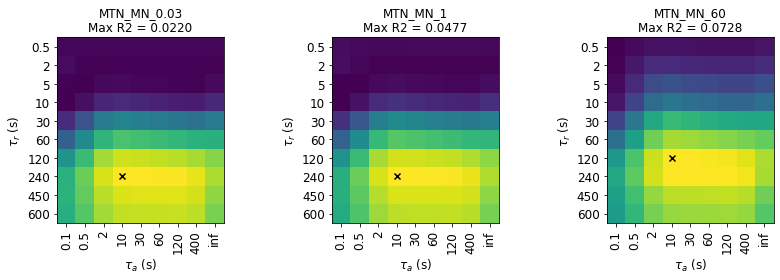

In [8]:
rslts = np.load(f'data/simple/mlv/ma_red/0C_single_tau_r_tau_a_sweep_pulse_sel.npy', allow_pickle=True)[0]
fig, axs = plt.subplots(1, 3, figsize=(12, 4), tight_layout=True)
for ax, targ in zip(axs, TARGS):
    ax.matshow(rslts['r2_test_mn_all'][targ])
    
    idx_best = np.unravel_index(
        rslts['r2_test_mn_all'][targ].flatten().argmax(),
        rslts['r2_test_mn_all'][targ].shape)
    
    max_r2 = rslts['r2_test_mn_all'][targ][idx_best[0], idx_best[1]]
    
    ax.scatter(idx_best[1], idx_best[0], c='k', marker='x', zorder=1)
    
    set_plot(
        ax,
        x_ticks=np.arange(len(rslts['tau_a_sweep'])),
        y_ticks=np.arange(len(rslts['tau_r_sweep'])),
        y_tick_labels=rslts['tau_r_sweep'],
        x_label=r'$\tau_a$ (s)',
        y_label=r'$\tau_r$ (s)',
        title=f'{targ}\nMax R2 = {max_r2:.4f}',
        font_size=12,
        )
    
    ax.set_xticklabels(rslts['tau_a_sweep'], rotation=90, fontsize=12)
    ax.xaxis.tick_bottom()

## Look for best response time constant

In [ ]:
# two-neuron population -- one sine detector, one pulse detector, sweep over response timescales
fname = '1_single_tau_r_sweep'
tau_r_sweep = [.1, .5, 1, 2, 5, 10, 20, 30, 60, 90, 120, 180, 240, 300, 450, 600]
r2_test_mn_all = {targ: [] for targ in TARGS}

for tau_r in tau_r_sweep:
    tau_rs = tau_r*np.ones(2)
    tau_as = np.inf*np.ones(2)
    x_ss = np.array([1, 0])
    x_ps = np.array([0, 1])
    
    r2_test_mns = record_fit(tau_rs, tau_as, x_ss, x_ps)[1]
    for targ in TARGS:
        r2_test_mn_all[targ].append(r2_test_mns[targ])
        
np.save(f'data/simple/mlv/ma_red/{fname}.npy', np.array([{
    'tau_r_sweep': tau_r_sweep,
    'r2_test_mn_all': r2_test_mn_all
}]))

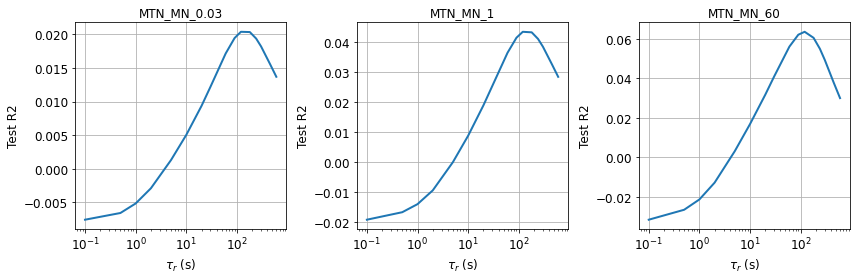

In [12]:
rslts = np.load(f'data/simple/mlv/ma_red/1_single_tau_r_sweep.npy', allow_pickle=True)[0]
fig, axs = plt.subplots(1, 3, figsize=(12, 4), tight_layout=True)
for ax, targ in zip(axs, TARGS):
    ax.semilogx(
        rslts['tau_r_sweep'],
        rslts['r2_test_mn_all'][targ],
        lw=2
    )
    set_plot(ax, x_label=r'$\tau_r$ (s)', y_label='Test R2', title=targ, font_size=12)
    ax.grid()

## Look for best adaptation time scale

In [ ]:
# two-neuron population -- one sine detector, one pulse detector, sweep over adaptation timescales
fname = '2_single_tau_a_sweep'
tau_a_sweep = [.1, .2, .5, 1, 2, 5, 10, 20, 30, 60, 120, 480, np.inf]
r2_test_mn_all = {targ: [] for targ in TARGS}

for tau_a in tau_a_sweep:
    tau_rs = 120.*np.ones(2)
    tau_as = tau_a*np.ones(2)
    x_ss = np.array([1, 0])
    x_ps = np.array([0, 1])
    
    r2_test_mns = record_fit(tau_rs, tau_as, x_ss, x_ps)[1]
    for targ in TARGS:
        r2_test_mn_all[targ].append(r2_test_mns[targ])
        
np.save(f'data/simple/mlv/ma_red/{fname}.npy', np.array([{
    'tau_a_sweep': tau_a_sweep,
    'r2_test_mn_all': r2_test_mn_all,
}]))

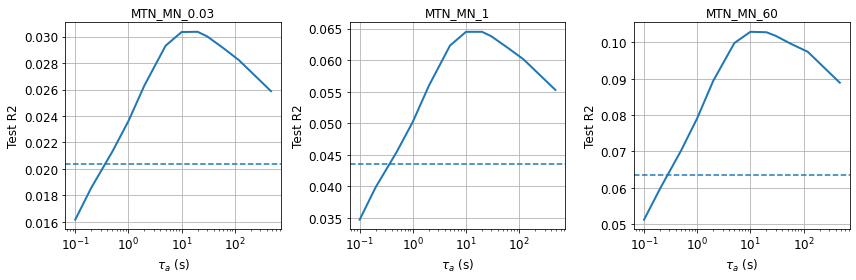

In [13]:
rslts = np.load(f'data/simple/mlv/ma_red/2_single_tau_a_sweep.npy', allow_pickle=True)[0]
fig, axs = plt.subplots(1, 3, figsize=(12, 4), tight_layout=True)
for ax, targ in zip(axs, TARGS):
    ax.semilogx(
        rslts['tau_a_sweep'][:-1],
        rslts['r2_test_mn_all'][targ][:-1],
        lw=2
    )
    ax.axhline(rslts['r2_test_mn_all'][targ][-1], ls='--')
    
    set_plot(ax, x_label=r'$\tau_a$ (s)', y_label='Test R2', title=targ, font_size=12)
    ax.grid()

## Look for best response timescales if independent for sine and pulse

In [ ]:
# 2 neurons
fname = '3_tau_r_sweep_indep'
tau_r_sweep = [.1, .5, 1, 2, 5, 10, 20, 30, 60, 90, 120, 180, 240, 300, 450, 600]
r2_test_mn_all = {targ: np.nan*np.eye(len(tau_r_sweep)) for targ in TARGS}

for ctau_r_s, tau_r_s in enumerate(tau_r_sweep):
    for ctau_r_p, tau_r_p in enumerate(tau_r_sweep):
        tau_rs = np.array([tau_r_s, tau_r_p])
        tau_as = np.inf*np.ones(2)
        x_ss = np.array([1, 0])
        x_ps = np.array([0, 1])

        r2_test_mns = record_fit(tau_rs, tau_as, x_ss, x_ps)[1]
        for targ in TARGS:
            r2_test_mn_all[targ][ctau_r_s, ctau_r_p] = r2_test_mns[targ]
        
np.save(f'data/simple/mlv/ma_red/{fname}.npy', np.array([{
    'tau_r_sweep': tau_r_sweep,
    'r2_test_mn_all': r2_test_mn_all,
}]))

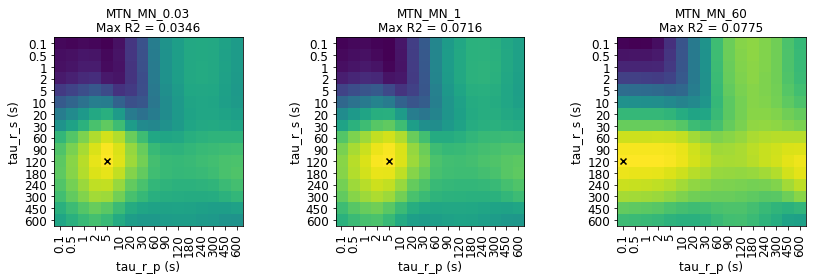

In [26]:
rslts = np.load(f'data/simple/mlv/ma_red/3_tau_r_sweep_indep.npy', allow_pickle=True)[0]
fig, axs = plt.subplots(1, 3, figsize=(12, 4), tight_layout=True)
for ax, targ in zip(axs, TARGS):
    ax.matshow(rslts['r2_test_mn_all'][targ], zorder=0)
    
    idx_best = np.unravel_index(
        rslts['r2_test_mn_all'][targ].flatten().argmax(),
        rslts['r2_test_mn_all'][targ].shape)
    
    max_r2 = rslts['r2_test_mn_all'][targ][idx_best[0], idx_best[1]]
    
    ax.scatter(idx_best[1], idx_best[0], c='k', marker='x', zorder=1)
    
    set_plot(
        ax,
        x_ticks=np.arange(len(rslts['tau_r_sweep'])),
        y_ticks=np.arange(len(rslts['tau_r_sweep'])),
        y_tick_labels=rslts['tau_r_sweep'],
        x_label='tau_r_p (s)',
        y_label='tau_r_s (s)',
        title=f'{targ}\nMax R2 = {max_r2:.4f}',
        font_size=12
    )
    
    ax.set_xticklabels(rslts['tau_r_sweep'], rotation=90, fontsize=12)
    ax.xaxis.tick_bottom()

## Look for best response timescales if independent for sine and pulse, and nonselective

In [8]:
# 3 neurons
fname = '4_tau_r_sweep_indep_s_p_non'

tau_r_sweep = [.1, 1, 5, 10, 30, 60, 120, 300, 600]
n_tau_r = len(tau_r_sweep)

r2_test_mn_all = {targ: np.nan*np.zeros(3*[n_tau_r]) for targ in TARGS}

for ctau_r_s, tau_r_s in enumerate(tau_r_sweep):
    for ctau_r_p, tau_r_p in enumerate(tau_r_sweep):
        for ctau_r_n, tau_r_n in enumerate(tau_r_sweep):
            tau_rs = np.array([tau_r_s, tau_r_p, tau_r_n])
            tau_as = np.inf*np.ones(3)
            x_ss = np.array([1, 0, .5])
            x_ps = np.array([0, 1, .5])

            r2_test_mns = record_fit(tau_rs, tau_as, x_ss, x_ps)[1]
            for targ in TARGS:
                r2_test_mn_all[targ][ctau_r_s, ctau_r_p, ctau_r_n] = r2_test_mns[targ]

np.save(f'data/simple/mlv/ma_red/{fname}.npy', np.array([{
    'tau_r_sweep': tau_r_sweep,
    'r2_test_mn_all': r2_test_mn_all,
}]))

RF..RF..RF..RF..RF..RF..RF..RF..RF..RF..RF..RF..RF..RF..RF..RF..RF..RF..RF..RF..RF..RF..RF..RF..RF..RF..RF..RF..RF..RF..RF..RF..RF..RF..RF..RF..RF..RF..RF..RF..RF..RF..RF..RF..RF..RF..RF..RF..RF..RF..RF..RF..RF..RF..RF..RF..RF..RF..RF..RF..RF..RF..RF..RF..RF..RF..RF..RF..RF..RF..RF..RF..RF..RF..RF..RF..RF..RF..RF..RF..RF..RF..RF..RF..RF..RF..RF..RF..RF..RF..RF..RF..RF..RF..RF..RF..RF..RF..RF..RF..RF..RF..RF..RF..RF..RF..RF..RF..RF..RF..RF..RF..RF..RF..RF..RF..RF..RF..RF..RF..RF..RF..RF..RF..RF..RF..RF..RF..RF..RF..RF..RF..RF..RF..RF..RF..RF..RF..RF..RF..RF..RF..RF..RF..RF..RF..RF..RF..RF..RF..RF..RF..RF..RF..RF..RF..RF..RF..RF..RF..RF..RF..RF..RF..RF..RF..RF..RF..RF..RF..RF..RF..RF..RF..RF..RF..RF..RF..RF..RF..RF..RF..RF..RF..RF..RF..RF..RF..RF..RF..RF..RF..RF..RF..RF..RF..RF..RF..RF..RF..RF..RF..RF..RF..RF..RF..RF..RF..RF..RF..RF..RF..RF..RF..RF..RF..RF..RF..RF..RF..RF..RF..RF..RF..RF..RF..RF..RF..RF..RF..RF..RF..RF..RF..RF..RF..RF..RF..RF..RF..RF..RF..RF..RF..RF..RF..RF..RF..RF..RF..

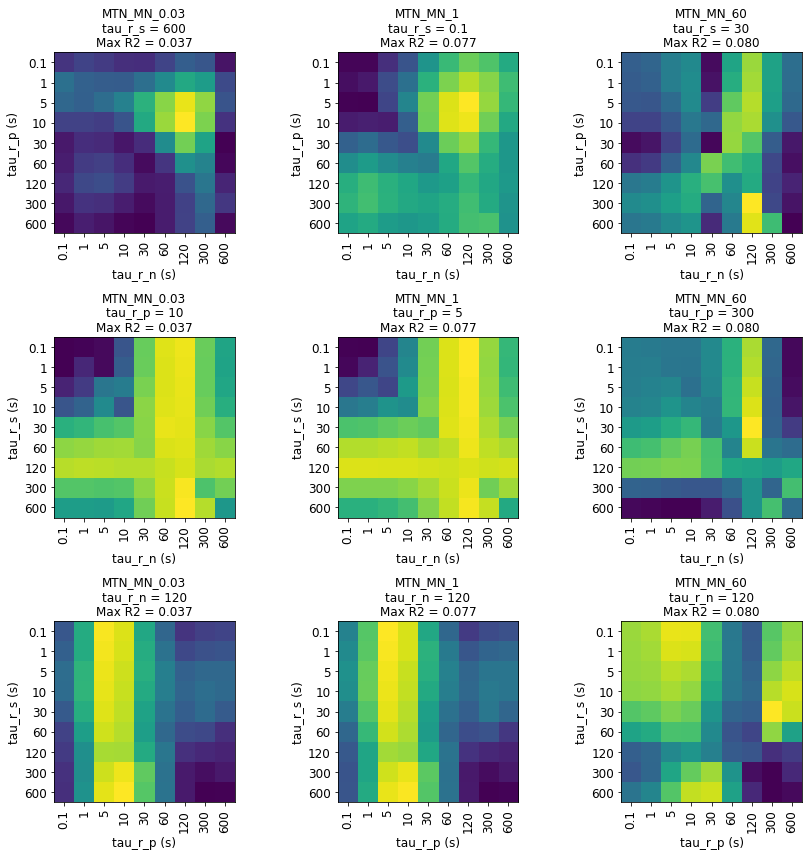

In [7]:
rslts = np.load(f'data/simple/mlv/ma_red/4_tau_r_sweep_indep_s_p_non.npy', allow_pickle=True)[0]
tau_r_sweep = rslts['tau_r_sweep']

# plot tau_r_s x tau_r_p, tau_r_s x tau_r_n, tau_r_p x tau_r_n, each containing best response
fig, axs = plt.subplots(3, 3, figsize=(12, 12), tight_layout=True)
for ax_col, targ in zip(axs.T, TARGS):
    
    r2_test_mn = rslts['r2_test_mn_all'][targ]
    idx_best = np.unravel_index(r2_test_mn.argmax(), r2_test_mn.shape)
    
    for cax, ax in enumerate(ax_col):
        
        if cax == 0:
            ax.matshow(r2_test_mn[idx_best[0], :, :])
            sub_title = f'tau_r_s = {tau_r_sweep[idx_best[0]]}'
            x_label = 'tau_r_n (s)'
            y_label = 'tau_r_p (s)'
            
        elif cax == 1:
            ax.matshow(r2_test_mn[:, idx_best[1], :])
            sub_title = f'tau_r_p = {tau_r_sweep[idx_best[1]]}'
            x_label = 'tau_r_n (s)'
            y_label = 'tau_r_s (s)'

        elif cax == 2:
            ax.matshow(r2_test_mn[:, :, idx_best[2]])
            sub_title = f'tau_r_n = {tau_r_sweep[idx_best[2]]}'
            x_label = 'tau_r_p (s)'
            y_label = 'tau_r_s (s)'
            
        set_plot(
            ax,
            x_ticks=np.arange(len(rslts['tau_r_sweep'])),
            y_ticks=np.arange(len(rslts['tau_r_sweep'])),
            y_tick_labels=rslts['tau_r_sweep'],
            x_label=x_label,
            y_label=y_label,
            title=f'{targ}\n{sub_title}\nMax R2 = {np.max(r2_test_mn):.3f}',
            font_size=12,
        )

        ax.set_xticklabels(rslts['tau_r_sweep'], rotation=90, fontsize=12)
        ax.xaxis.tick_bottom()

## Look for best sine & pulse adaptation timescales given best response timescales

In [ ]:
x = np.array([[1, 2, 3, 4, 5], [5, 4, 3, 2, 1]])
fig, ax = plt.subplots(1, 1)
ax.matshow(x)

In [ ]:
# 2 neurons
fname = '5_tau_a_sweep_indep'

tau_a_sweep = [.1, .2, .5, 1, 2, 5, 10, 20, 30, 60, 120, 480, np.inf]
r2_test_mn_all = {targ: np.nan*np.eye(len(tau_a_sweep)) for targ in TARGS}

for ctau_a_s, tau_a_s in enumerate(tau_a_sweep):
    for ctau_a_p, tau_a_p in enumerate(tau_a_sweep):
        tau_rs = np.array([120, 5])
        tau_as = np.array([tau_a_s, tau_a_p])
        x_ss = np.array([1, 0])
        x_ps = np.array([0, 1])

        r2_test_mns = record_fit(tau_rs, tau_as, x_ss, x_ps)[1]
        for targ in TARGS:
            r2_test_mn_all[targ][ctau_a_s, ctau_a_p] = r2_test_mns[targ]
        
np.save(f'data/simple/mlv/ma_red/{fname}.npy', np.array([{
    'tau_a_sweep': tau_a_sweep,
    'r2_test_mn_all': r2_test_mn_all,
}]))

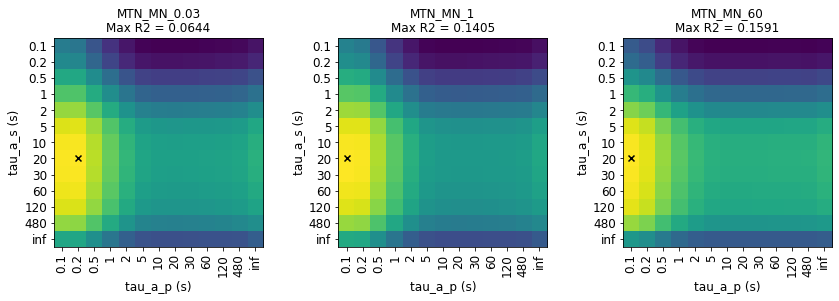

In [8]:
rslts = np.load(f'data/simple/mlv/ma_red/5_tau_a_sweep_indep.npy', allow_pickle=True)[0]
fig, axs = plt.subplots(1, 3, figsize=(12, 4), tight_layout=True)
for ax, targ in zip(axs, TARGS):
    ax.matshow(rslts['r2_test_mn_all'][targ], zorder=0)
    
    idx_best = np.unravel_index(
        rslts['r2_test_mn_all'][targ].flatten().argmax(),
        rslts['r2_test_mn_all'][targ].shape)
    
    max_r2 = rslts['r2_test_mn_all'][targ][idx_best[0], idx_best[1]]
    
    ax.scatter(idx_best[1], idx_best[0], c='k', marker='x', zorder=1)
    
    set_plot(
        ax,
        x_ticks=np.arange(len(rslts['tau_a_sweep'])),
        y_ticks=np.arange(len(rslts['tau_a_sweep'])),
        y_tick_labels=rslts['tau_a_sweep'],
        x_label='tau_a_p (s)',
        y_label='tau_a_s (s)',
        title=f'{targ}\nMax R2 = {max_r2:.4f}',
        font_size=12
    )
    
    ax.set_xticklabels(rslts['tau_a_sweep'], rotation=90, fontsize=12)
    ax.xaxis.tick_bottom()

## Look for best additional nonselective neuron given top two sine & pulse neurons

In [ ]:
# 3 neurons - first two are greedily optimized sine & pulse adaptive neurons, third sweeps over tau_r & tau_a but is nonselective
fname = '6A_best_third_nrn_non'

tau_r_sweep = [.1, .5, 2, 5, 10, 30, 60, 120]
tau_a_sweep = [.1, .5, 2, 5, 10, 30, 60, 120, np.inf]

r2_test_mn_all = {targ: np.nan*np.zeros((len(tau_r_sweep), len(tau_a_sweep))) for targ in TARGS}

for ctau_r, tau_r in enumerate(tau_r_sweep):
    for ctau_a, tau_a in enumerate(tau_a_sweep):
        tau_rs = np.array([120, 5, tau_r])
        tau_as = np.array([20, .1, tau_a])
        x_ss = np.array([1, 0, .5])
        x_ps = np.array([0, 1, .5])

        r2_test_mns = record_fit(tau_rs, tau_as, x_ss, x_ps)[1]
        for targ in TARGS:
            r2_test_mn_all[targ][ctau_r, ctau_a] = r2_test_mns[targ]
        
np.save(f'data/simple/mlv/ma_red/{fname}.npy', np.array([{
    'tau_r_sweep': tau_r_sweep,
    'tau_a_sweep': tau_a_sweep,
    'r2_test_mn_all': r2_test_mn_all,
}]))

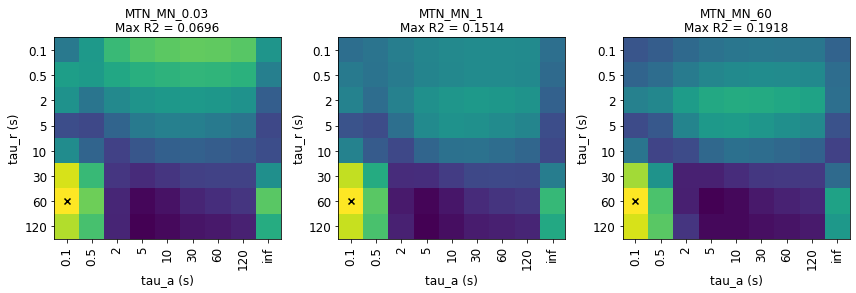

In [8]:
rslts = np.load(f'data/simple/mlv/ma_red/6A_best_third_nrn_non.npy', allow_pickle=True)[0]
fig, axs = plt.subplots(1, 3, figsize=(12, 4), tight_layout=True)
for ax, targ in zip(axs, TARGS):
    ax.matshow(rslts['r2_test_mn_all'][targ], zorder=0)
    
    idx_best = np.unravel_index(
        rslts['r2_test_mn_all'][targ].flatten().argmax(),
        rslts['r2_test_mn_all'][targ].shape)
    
    max_r2 = rslts['r2_test_mn_all'][targ][idx_best[0], idx_best[1]]
    
    ax.scatter(idx_best[1], idx_best[0], c='k', marker='x', zorder=1)
    
    set_plot(
        ax,
        x_ticks=np.arange(len(rslts['tau_a_sweep'])),
        y_ticks=np.arange(len(rslts['tau_r_sweep'])),
        y_tick_labels=rslts['tau_r_sweep'],
        x_label='tau_a (s)',
        y_label='tau_r (s)',
        title=f'{targ}\nMax R2 = {max_r2:.4f}',
        font_size=12
    )
    
    ax.set_xticklabels(rslts['tau_a_sweep'], rotation=90, fontsize=12)
    ax.xaxis.tick_bottom()

## Look for best additional sine-selective neuron given top two sine & pulse neurons

In [ ]:
# 3 neurons - first two are greedily optimized sine & pulse adaptive neurons, third sweeps over tau_r & tau_a but is nonselective
fname = '6B_best_third_nrn_sine'

tau_r_sweep = [.1, .5, 2, 5, 10, 30, 60, 120]
tau_a_sweep = [.1, .5, 2, 5, 10, 30, 60, 120, np.inf]

r2_test_mn_all = {targ: np.nan*np.zeros((len(tau_r_sweep), len(tau_a_sweep))) for targ in TARGS}

for ctau_r, tau_r in enumerate(tau_r_sweep):
    for ctau_a, tau_a in enumerate(tau_a_sweep):
        tau_rs = np.array([120, 5, tau_r])
        tau_as = np.array([20, .1, tau_a])
        x_ss = np.array([1, 0, 1])
        x_ps = np.array([0, 1, 0])

        r2_test_mns = record_fit(tau_rs, tau_as, x_ss, x_ps)[1]
        for targ in TARGS:
            r2_test_mn_all[targ][ctau_r, ctau_a] = r2_test_mns[targ]
        
np.save(f'data/simple/mlv/ma_red/{fname}.npy', np.array([{
    'tau_r_sweep': tau_r_sweep,
    'tau_a_sweep': tau_a_sweep,
    'r2_test_mn_all': r2_test_mn_all,
}]))

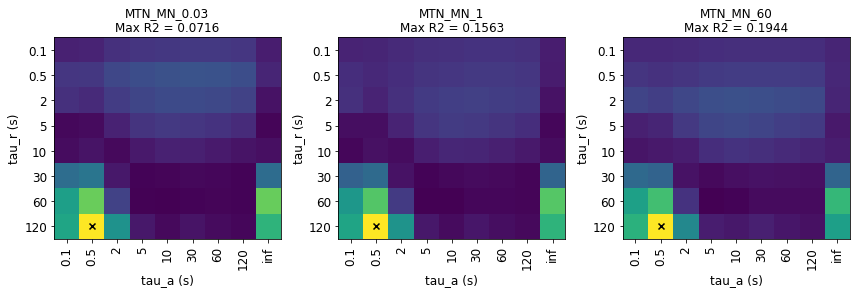

In [9]:
rslts = np.load(f'data/simple/mlv/ma_red/6B_best_third_nrn_sine.npy', allow_pickle=True)[0]
fig, axs = plt.subplots(1, 3, figsize=(12, 4), tight_layout=True)
for ax, targ in zip(axs, TARGS):
    ax.matshow(rslts['r2_test_mn_all'][targ], zorder=0)
    
    idx_best = np.unravel_index(
        rslts['r2_test_mn_all'][targ].flatten().argmax(),
        rslts['r2_test_mn_all'][targ].shape)
    
    max_r2 = rslts['r2_test_mn_all'][targ][idx_best[0], idx_best[1]]
    
    ax.scatter(idx_best[1], idx_best[0], c='k', marker='x', zorder=1)
    
    set_plot(
        ax,
        x_ticks=np.arange(len(rslts['tau_a_sweep'])),
        y_ticks=np.arange(len(rslts['tau_r_sweep'])),
        y_tick_labels=rslts['tau_r_sweep'],
        x_label='tau_a (s)',
        y_label='tau_r (s)',
        title=f'{targ}\nMax R2 = {max_r2:.4f}',
        font_size=12
    )
    
    ax.set_xticklabels(rslts['tau_a_sweep'], rotation=90, fontsize=12)
    ax.xaxis.tick_bottom()

## Look for best additional pulse-selective neuron given top two sine & pulse neurons

In [ ]:
# 3 neurons - first two are greedily optimized sine & pulse adaptive neurons, third sweeps over tau_r & tau_a but is nonselective
fname = '6C_best_third_nrn_pulse'

tau_r_sweep = [.1, .5, 2, 5, 10, 30, 60, 120]
tau_a_sweep = [.1, .5, 2, 5, 10, 30, 60, 120, np.inf]

r2_test_mn_all = {targ: np.nan*np.zeros((len(tau_r_sweep), len(tau_a_sweep))) for targ in TARGS}

for ctau_r, tau_r in enumerate(tau_r_sweep):
    for ctau_a, tau_a in enumerate(tau_a_sweep):
        tau_rs = np.array([120, 5, tau_r])
        tau_as = np.array([20, .1, tau_a])
        x_ss = np.array([1, 0, 0])
        x_ps = np.array([0, 1, 1])

        r2_test_mns = record_fit(tau_rs, tau_as, x_ss, x_ps)[1]
        for targ in TARGS:
            r2_test_mn_all[targ][ctau_r, ctau_a] = r2_test_mns[targ]
        
np.save(f'data/simple/mlv/ma_red/{fname}.npy', np.array([{
    'tau_r_sweep': tau_r_sweep,
    'tau_a_sweep': tau_a_sweep,
    'r2_test_mn_all': r2_test_mn_all,
}]))

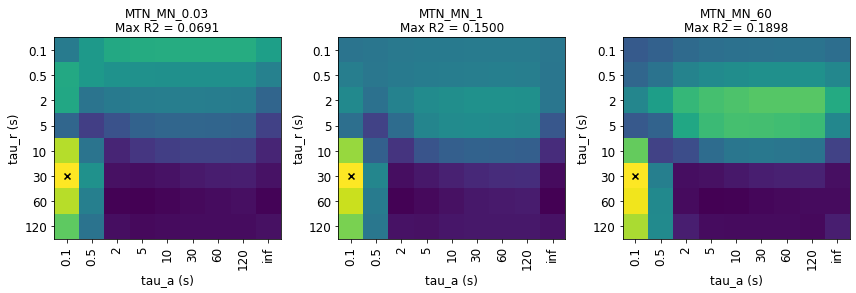

In [11]:
rslts = np.load(f'data/simple/mlv/ma_red/6C_best_third_nrn_pulse.npy', allow_pickle=True)[0]
fig, axs = plt.subplots(1, 3, figsize=(12, 4), tight_layout=True)
for ax, targ in zip(axs, TARGS):
    ax.matshow(rslts['r2_test_mn_all'][targ], zorder=0)
    
    idx_best = np.unravel_index(
        rslts['r2_test_mn_all'][targ].flatten().argmax(),
        rslts['r2_test_mn_all'][targ].shape)
    
    max_r2 = rslts['r2_test_mn_all'][targ][idx_best[0], idx_best[1]]
    
    ax.scatter(idx_best[1], idx_best[0], c='k', marker='x', zorder=1)
    
    set_plot(
        ax,
        x_ticks=np.arange(len(rslts['tau_a_sweep'])),
        y_ticks=np.arange(len(rslts['tau_r_sweep'])),
        y_tick_labels=rslts['tau_r_sweep'],
        x_label='tau_a (s)',
        y_label='tau_r (s)',
        title=f'{targ}\nMax R2 = {max_r2:.4f}',
        font_size=12
    )
    
    ax.set_xticklabels(rslts['tau_a_sweep'], rotation=90, fontsize=12)
    ax.xaxis.tick_bottom()